In [1]:
#导入相关工具包
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest
import warnings
from sklearn.model_selection import StratifiedKFold, KFold
warnings.filterwarnings('ignore')
plt.rcParams['font.sans-serif']=['SimHei'] #黑体，没有此行会显示缺少字体的错误提示

In [2]:
data_test = pd.read_csv('test_public.csv')

In [3]:
data_test.shape

(5000, 38)

In [4]:
#查找出数据中的对象特征和数值特征
numerical_fea = list(data_test.select_dtypes(exclude=['object']).columns)
category_fea = list(filter(lambda x: x not in numerical_fea,list(data_test.columns)))

### 时间格式处理

In [5]:
# 日期类型：issueDate，earliesCreditLine
# 转换为pandas中的日期类型
data_test['issue_date'] = pd.to_datetime(data_test['issue_date'])
# 提取多尺度特征
data_test['issue_date_y'] = data_test['issue_date'].dt.year
data_test['issue_date_m'] = data_test['issue_date'].dt.month
# 提取时间diff
# 设置初始的时间
base_time = datetime.datetime.strptime('2007-06-01', '%Y-%m-%d')
# 转换为天为单位
data_test['issue_date_diff'] = data_test['issue_date'].apply(lambda x: x-base_time).dt.days
data_test[['issue_date', 'issue_date_y', 'issue_date_m', 'issue_date_diff']]
data_test.drop('issue_date', axis = 1, inplace = True)

In [6]:
#时间格式处理
df1=data_test[[ 'user_id','issue_date_y', 'issue_date_m', 'issue_date_diff']]
df1=df1.reset_index(drop=True)
df1.shape

(5000, 4)

### 类别特征处理

In [7]:
from sklearn import preprocessing
le=preprocessing.LabelEncoder()
le.fit(data_test['earlies_credit_mon'].values)
data_test['earlies_credit_mon']=le.transform(data_test['earlies_credit_mon'].values)

In [8]:
# 部分类别特征
cate_features = ['class','employer_type' ,'industry','work_year','earlies_credit_mon']
for f in cate_features:
    print(f, '类型数：', data_test[f].nunique())

class 类型数： 7
employer_type 类型数： 6
industry 类型数： 14
work_year 类型数： 11
earlies_credit_mon 类型数： 476


In [9]:
data_test['class'] = data_test['class'].map({'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6})

In [10]:
for data in [data_test]:
    data = pd.get_dummies(data, columns=[ 'employer_type', 'industry', 'work_year'], drop_first=True)

In [11]:
data_test=data
data_test.shape

(5000, 65)

### 缺失值处理

In [12]:
#显示所有行
#pd.set_option('display.max_rows',None)
data_test.isnull().sum()

loan_id               0
user_id               0
total_loan            0
year_of_loan          0
interest              0
                     ..
work_year_6 years     0
work_year_7 years     0
work_year_8 years     0
work_year_9 years     0
work_year_< 1 year    0
Length: 65, dtype: int64

In [13]:
#删除policy_code和loan_id
numerical_fea.remove('policy_code')
numerical_fea.remove('loan_id')

In [14]:
#按照平均数填充数值型特征
data_test[numerical_fea] = data_test[numerical_fea].fillna(data_test[numerical_fea].median())

### 数据分桶

In [15]:
#过滤数值型类别特征
def get_numerical_serial_fea(data,feas):
    numerical_serial_fea = []
    numerical_noserial_fea = []
    for fea in feas:
        temp = data[fea].nunique()
        if temp <= 10:
            numerical_noserial_fea.append(fea)
            continue
        numerical_serial_fea.append(fea)
    return numerical_serial_fea,numerical_noserial_fea
numerical_serial_fea,numerical_noserial_fea = get_numerical_serial_fea(data_test,numerical_fea)

In [16]:
len(numerical_serial_fea),len(numerical_noserial_fea)

(21, 9)

In [17]:
data1=data_test.loc[:,numerical_serial_fea]

In [18]:
#查看数值型的标准差
data1_std=data1.std().sort_values(ascending=False)
pd.DataFrame(data1_std,columns=['std']).head(10)

,std
recircle_b,21757.810210
user_id,14431.348968
total_loan,8755.784815
title,7971.472766
early_return_amount,2995.760578
early_return_amount_3mon,623.447110
monthly_payment,251.272924
post_code,201.484039
scoring_high,100.014385
scoring_low,76.529284


In [19]:
data1_index=['recircle_b','total_loan','title','early_return_amount']

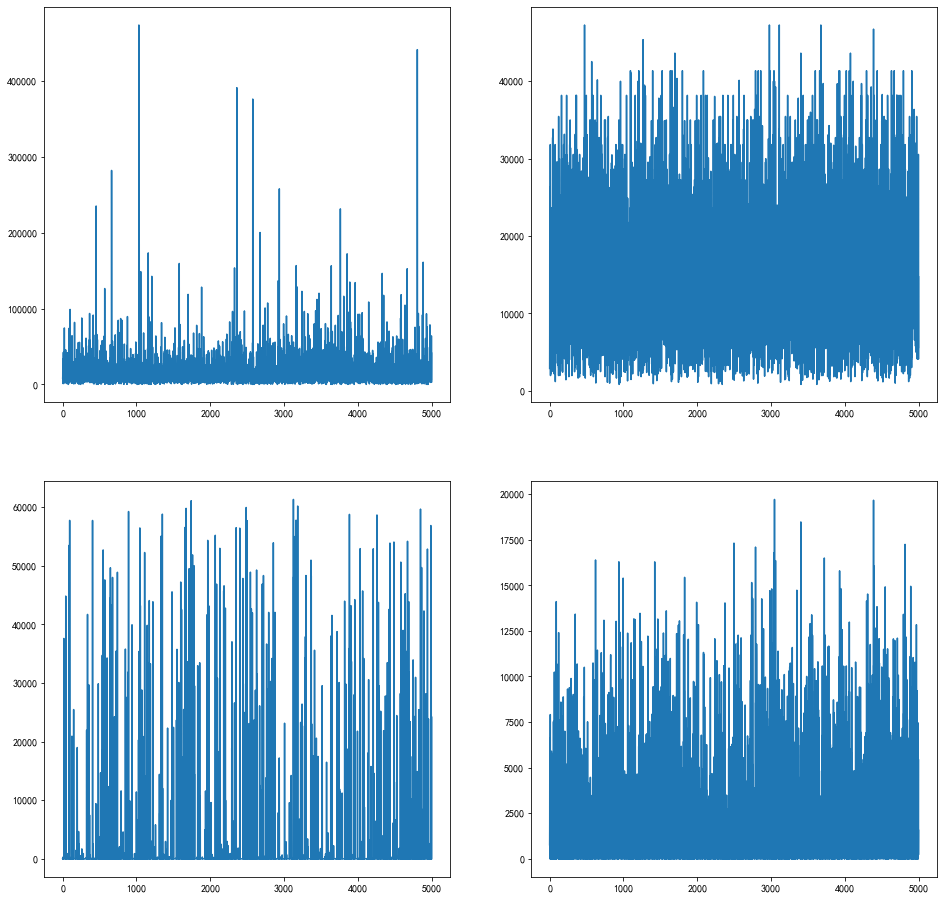

In [20]:
#对标准差大于1000的画图
dist_cols=2
dist_rows=2
plt.figure(figsize=(8*dist_cols,8*dist_rows))
i=1
for col in data1_index:
    ax=plt.subplot(dist_rows,dist_cols,i)
    ax=plt.plot(data1[col])
    i+=1
plt.show()

In [21]:
#对data1_index分箱处理
for i in data1_index:
    data1[i] = pd.qcut(data1[i], 10, labels=False,duplicates='drop')

### 特征交互

In [22]:
data2=data1.iloc[:,1:]

In [23]:
from sklearn.preprocessing import PolynomialFeatures
#多项式特征构造
poly = PolynomialFeatures(degree=3, include_bias=True)
poly.fit(data2)
X_poly = poly.transform(data2)
X_poly.shape

(5000, 1771)

In [24]:
data3=pd.DataFrame(X_poly,index=data1['user_id'])
data3=data3.rename_axis('user_id').reset_index()
data3.shape

(5000, 1772)

In [25]:
#将数据合并
data4=pd.merge(df1,data_test,on='user_id')
data5=pd.merge(data4,data3,on='user_id')
data5.shape

(5000, 1839)

### 特征筛选

In [27]:
##方差筛选
from sklearn.feature_selection import VarianceThreshold
var_selector = VarianceThreshold(threshold = 1)#设置方差过滤阈值为1
var_selector.fit_transform(data5)
is_select = var_selector.get_support()#get_support函数返回方差＞阈值的布尔值序列
var_feature = data5.iloc[:,is_select]#根据布尔值序列取出各个特征所在列

In [29]:
##相关性筛选
from sklearn.feature_selection import mutual_info_regression
append_frame = var_feature#先复制dataFrame
corr = append_frame.corr()
corr_series = pd.Series(data = corr.iloc[-1,:-1])
corr_sort = corr_series.abs().sort_values(ascending = False)


Text(0.5, 1.0, '基于相关系数的相关性筛选')

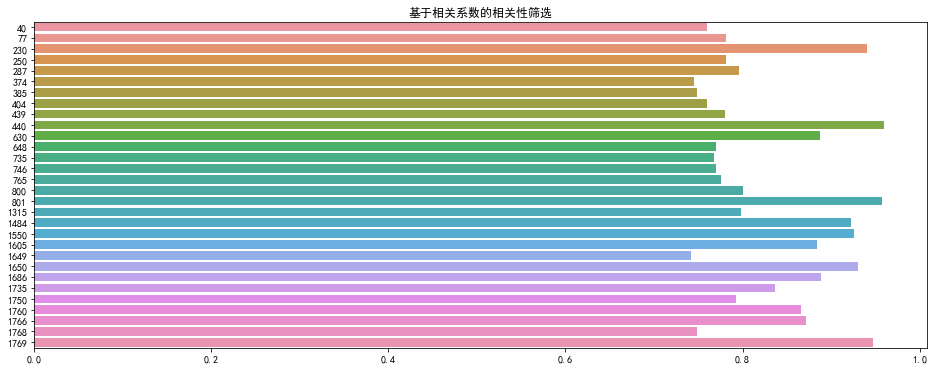

In [30]:
plt.figure(figsize=(16,6))
sns.barplot(corr_sort.values[:30], corr_sort.index[:30], orient='h')
plt.title("基于相关系数的相关性筛选")

In [31]:
data6=data5.loc[:,corr_sort.index[:30]]
data6.to_csv('test30.csv')